In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("stock_data.csv", encoding = "ISO-8859-1", engine='python')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [4]:
data["Sentiment"] = data["Sentiment"].replace(-1,0)

I want to see sentiment value counts.

In [5]:
data["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

and I want to see this values with graphics.

C:\Users\mseli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


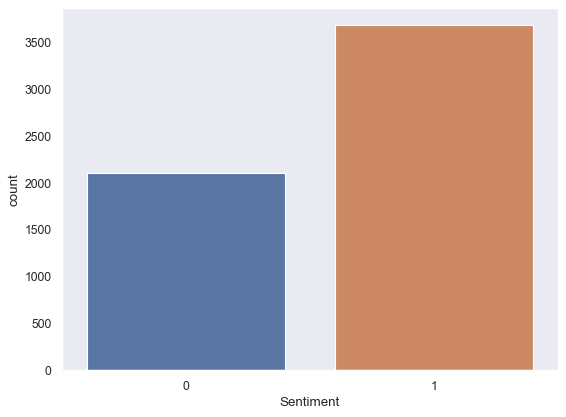

In [6]:
fig = plt.figure(figsize=(8, 6), dpi=80)
sns.set_theme(style="dark")
sns.countplot(data["Sentiment"])

I want to control the distribution of word count.

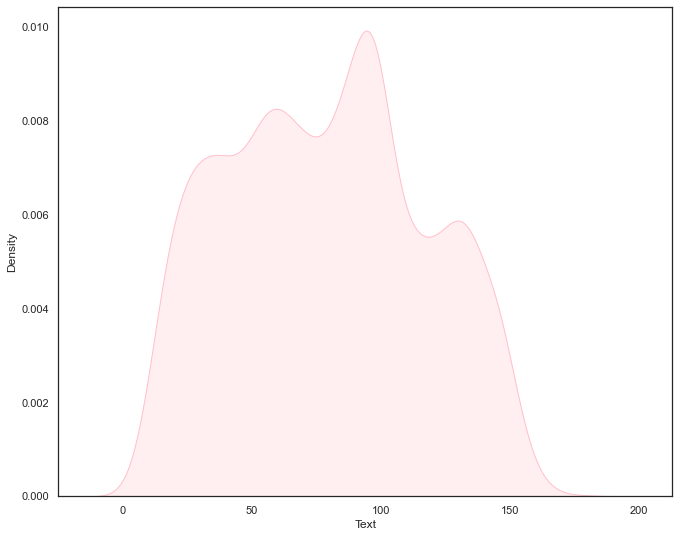

In [7]:
fig = plt.figure(figsize=(11, 9))
sns.set_theme(style="white")
leng = data["Text"].str.len()
sns.kdeplot(leng, fill=True, common_norm=False, color = "pink")

We define our tools for data preprocessing and do all data preprocessing in a loop.

In [8]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [9]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

In [10]:
data = pd.DataFrame(data = data)
text_reviews = list()
for i in range(len(data)):
    text = re.sub('[^a-zA-Z]'," ",data['Text'][i])
    text = text.lower()
    text = word_tokenize(text,language="english")
    text = [lemma.lemmatize(word) for word in text if(word) not in stopwordSet]
    text = " ".join(text)
    text_reviews.append(text)

We're in the feature extraction part. In this section, we will create vectors that represent our texts and train our models according to these vectors. It is one of the important factors affecting the success of the model. I evaluated 2 of the 2 different methods and commented on the unsuccessful one.

In fact, we have 2 models that we can consider successful. Count vectorizer fails only for logistic regression.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, encoding='utf-8',
 decode_error='ignore')

In [12]:
'''from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary= False, ngram_range = (1,2))'''

'from sklearn.feature_extraction.text import CountVectorizer\nvectorizer = CountVectorizer(binary= False, ngram_range = (1,2))'

In [13]:
vectorizer.fit(text_reviews)
X = vectorizer.transform(text_reviews)
y= data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, random_state = 42)

In [14]:
logreg = LogisticRegression(random_state = 21, solver = "saga", C = 8, penalty = 'l2')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [15]:
print("\n\naccuracy: {}".format(accuracy_score(y_test, y_pred)))



accuracy: 0.7946505608283002


We are using Support Vector Machines.

In [16]:
from sklearn import svm
svm = svm.SVC(C = 5 , kernel='rbf')

In [17]:
svm.fit(X_train, y_train)
y_pred3 = svm.predict(X_test)
print("\n\naccuracy: {}".format(accuracy_score(y_test, y_pred3)))



accuracy: 0.7963761863675582


We are using XGBClassifier.

In [18]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimator = 500, max_depth = 5, learning_rate = 0.5)
xgb.fit(X_train, y_train)

[17:36:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator=500, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [19]:
y_pred4 = xgb.predict(X_test)
print("\n\naccuracy: {}".format(accuracy_score(y_test, y_pred4)))



accuracy: 0.7679033649698016


We are using LightGBM.

In [20]:
from lightgbm import LGBMClassifier


In [21]:
Y_train = y_train.astype('float32')
Y_test = y_test.astype('float32')
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')

In [22]:
lgb = LGBMClassifier(learning_rate = 0.10, n_estimator = 500, max_depth = 8)

In [23]:
lgb.fit(x_train, Y_train)

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


LGBMClassifier(max_depth=8, n_estimator=500)

In [24]:
y_pred5 = lgb.predict(x_test)

In [25]:
print("\n\naccuracy: {}".format(accuracy_score(y_test, y_pred5)))



accuracy: 0.7515099223468508


In [26]:
x_train = x_train.toarray()
x_test = x_test.toarray()

We are using Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

In [28]:
y_pred6 = nb.predict(x_test)

In [30]:
print("\n\naccuracy: {}".format(accuracy_score(y_test, y_pred6)))



accuracy: 0.5936151855047455
